Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
import copy

import numpy as np
from models import *
from models.SkipDIP import SkipDIP

import torch
import torch.optim

from skimage.measure import compare_psnr, compare_ssim, compare_mse
# from skimage.metrics import mean_squared_error

from models.downsampler import Downsampler

from utils.sr_utils import *

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

torch.manual_seed(1)
np.random.seed(1)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.enabled = True
# torch.backends.cudnn.benchmark = False
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True


# Load image and baselines

HR and LR resolutions: (288, 288), (72, 72)


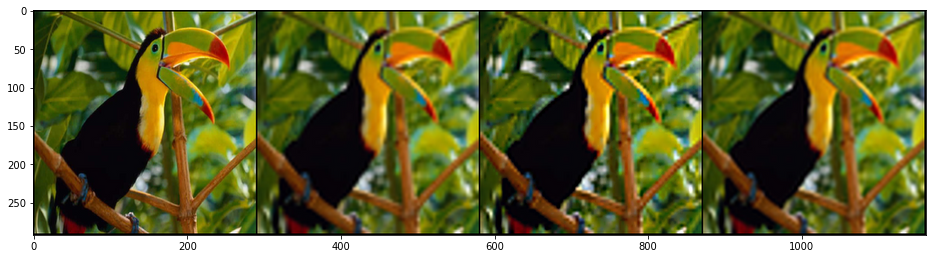

PSNR bicubic: 30.3911   PSNR lanczos: 30.7954
SSIM bicubic: 0.9319   SSIM lanczos: 0.9369


In [2]:
path_to_image = 'data/sr/set5/bird.png'
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['lanczos_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

psnr_bicubic = compare_psnr_y(imgs['HR_np'], imgs['bicubic_np'])
psnr_lanczos = compare_psnr_y(imgs['HR_np'], imgs['lanczos_np'])
ssim_bicubic = compare_ssim_y(imgs['HR_np'], imgs['bicubic_np'])
ssim_lanczos = compare_ssim_y(imgs['HR_np'], imgs['lanczos_np'])
# ssim_bicubic = compare_ssim_y(np.transpose(imgs['HR_np'], (1, 2, 0)), np.transpose(imgs['bicubic_np'], (1, 2, 0)), multichannel=True)
# ssim_lanczos = compare_ssim_y(np.transpose(imgs['HR_np'], (1, 2, 0)), np.transpose(imgs['lanczos_np'], (1, 2, 0)), multichannel=True)

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['lanczos_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR lanczos: %.4f' %  (psnr_bicubic, psnr_lanczos))
    print ('SSIM bicubic: %.4f   SSIM lanczos: %.4f' %  (ssim_bicubic, ssim_lanczos))

# Set up parameters and net

In [3]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

if factor == 4: 
    num_iter = 2500
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [4]:
net_input_1 = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

net = SkipDIP(num_input_channels=32,
              num_output_channels=3,
              num_channels_down=[128, 128, 128, 128, 128],
              num_channels_up=[128, 128, 128, 128, 128],
              act_fun='ReLU').type(dtype)

net = net.cuda()
init_weights = net.state_dict()

In [5]:
# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)
img_LR_var_clone = img_LR_var.clone().detach()
img_HR_var = np_to_torch(imgs['HR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [6]:
def closure():
    global i, net_input_1
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    
    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var)
    total_loss.backward()

    # Log
#     psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = compare_psnr_y(imgs['HR_np'], torch_to_np(out_HR))
    ssim_HR = compare_ssim_y(imgs['HR_np'], torch_to_np(out_HR))
    mse_HR = compare_mse(imgs['HR_np'], torch_to_np(out_HR))
    
#     ssim_HR = compare_ssim(np.transpose(imgs['HR_np'], (1, 2, 0)), np.transpose(torch_to_np(out_HR), (1, 2, 0)), multichannel=True)
    print ('Iteration %05d    PSNR_HR %.3f   SSIM_HR %.3f   Loss %.6f' % (i, psnr_HR, ssim_HR, total_loss.data), '\r', end='')
    
    if PLOT and (i % 100 == 0):
        psnr_history.append(psnr_HR)
        ssim_history.append(ssim_HR)
        iter_history.append(i)
        loss_history.append(total_loss.data)
        mse_history.append(mse_HR)
#         out_HR_np = torch_to_np(out_HR)
#         plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['lanczos_np'], np.clip(out_HR_np, 0, 1)], factor=8, nrow=2)

    i += 1
    
    return total_loss

In [7]:
psnr_history = []
mse_history = []
ssim_history = []
iter_history = []
loss_history = []

net_input_saved = net_input_1.detach().clone()
noise = net_input_1.detach().clone()

i = 0

dip_params = get_params(OPT_OVER, net, net_input_1)
# mask_params = get_params(OPT_OVER, mask_net, net_input_1)

# for a in net.named_parameters():
#     print(a[0])
# print('------------------')
# for a in mask_net.named_parameters():
#     print(a[0])
# mask.requires_grad = True

In [8]:
optimizer = torch.optim.Adam([{'params': dip_params, 'lr': 0.001}])
# parameters = dip_params + mask_params


for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


PSNR:  32.43772617373538
SSIM:  0.9565988067144255
RMSE:  0.030599390266268556
(3, 288, 288)


/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/anuj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


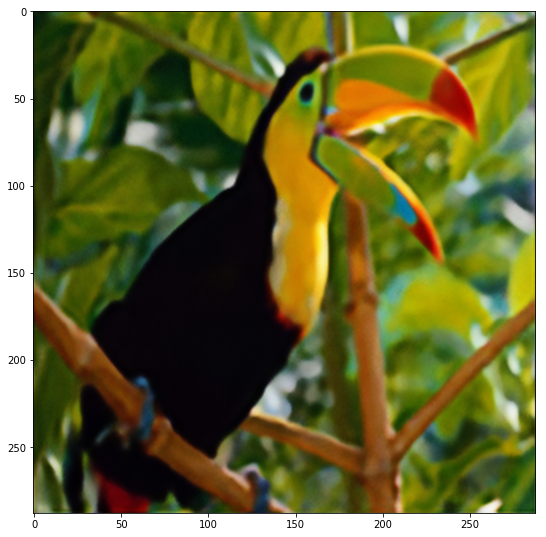

/home/anuj/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [9]:
out_HR = net(net_input_1)
psnr_HR = compare_psnr_y(imgs['HR_np'], torch_to_np(out_HR))
ssim_HR = compare_ssim_y(imgs['HR_np'], torch_to_np(out_HR))
mse_HR = compare_mse(imgs['HR_np'], torch_to_np(out_HR))
    
# ssim_HR = compare_ssim(np.transpose(imgs['HR_np'], (1, 2, 0)), np.transpose(torch_to_np(out_HR), (1, 2, 0)), multichannel=True)

print("PSNR: ", psnr_HR)
print("SSIM: ", ssim_HR)
print("RMSE: ", mse_HR**0.5)

out_HR_np = np.clip(torch_to_np(out_HR), 0, 1)
print(out_HR_np.shape)
plot_image_grid([out_HR_np], factor=8, nrow=1)

# Save image
file_path = 'data/sr/set5/res/bird_dip_1.png'
import skimage.io as sio
sio.imsave(file_path, np.transpose(out_HR_np, (1, 2, 0)))

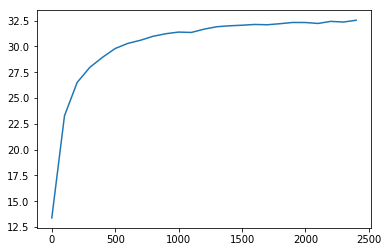

In [10]:
plt.plot(iter_history, psnr_history)

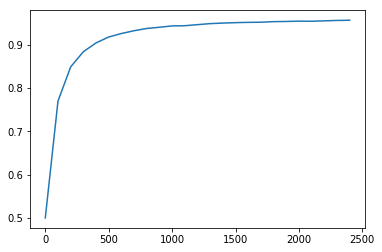

In [11]:
plt.plot(iter_history, ssim_history)

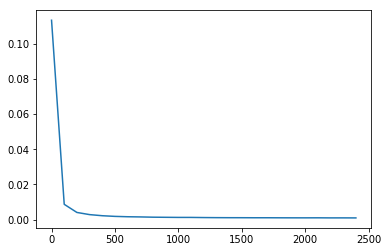

In [12]:
plt.plot(iter_history, mse_history)